# Tâche LEGO avec le modèle BERT

Dans ce notebook, nous importons et entraînons sur la tâche LEGO un modèle BERT.

In [1]:
import torch
import torch.nn as nn
import numpy as np
from transformers import BertTokenizer, BertConfig, BertModel
import os
import math
import time
from datetime import datetime
from matplotlib import pyplot as plt
import pickle

Nous fixons l'état des fonctions aléatoires:

In [2]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(0)

Ci-dessous, nous définissons diverses variables utiles par la suite.

In [3]:
all_vars = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# n_var: total number of variables in a chain
# n_train_var: number of variables to provide supervision during training
n_var, n_train_var = 6, 3

# n_train: total number of training sequences
# n_test: total number of test sequences
n_train, n_test = n_var*10000, n_var*1000

batch_size = 200

# use_pretrained_transformer: whether to use a pretrained transformer as base model
use_pretrained_transformer = True

Les fonctions ci-dessous servent à générer les données:

In [4]:
def generate_data(tokenizer, n_var, batch_size=100):
    
    batch = []
    labels = []
    clause_order = []
    for _ in range(batch_size):
        values = np.random.randint(0, 2, (n_var,))
        var_idx = tuple(np.random.permutation(len(all_vars)))
        vars = [all_vars[i] for i in var_idx]

        # generate first sentence
        clauses = []
        clauses.append('%s = val %d , ' % (vars[0], values[0]))

        for i in range(1, n_var):
            modifier = 'val' if values[i] == values[i-1] else 'not'
            clauses.append(' %s = %s %s , ' % (vars[i], modifier, vars[i-1]))
            

        sent = ''
        label = []
        
        clause_idx = tuple(np.random.permutation(n_var))
        sent += ''.join([clauses[idx] for idx in clause_idx])
        label += [values[idx] for idx in clause_idx]
        
        
        order = torch.zeros(1, n_var, n_var)
        for i in range(n_var):
            order[0, i, clause_idx[i]] = 1
            
        batch.append(tokenizer(sent, return_tensors='pt')['input_ids'])
        labels.append(values)
        clause_order.append(order)
    return torch.cat(batch), torch.LongTensor(labels), torch.cat(clause_order)


def make_lego_datasets(tokenizer, n_var, n_train, n_test, batch_size):
    
    train_data = []
    train_labels = []
    train_order = []

    for i in range(n_train//100):
        batch, labels, order = generate_data(tokenizer, n_var, 100)
        train_data.append(batch)
        train_labels.append(labels)
        train_order.append(order)

    x_train = torch.cat(train_data)
    y_train = torch.cat(train_labels)
    order_train = torch.cat(train_order)
    
    trainset = torch.utils.data.TensorDataset(x_train, y_train, order_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    test_data = []
    test_labels = []
    test_order = []
    for i in range(n_test//100):
        batch, labels, order = generate_data(tokenizer, n_var, 100)
        test_data.append(batch)
        test_labels.append(labels)
        test_order.append(order)

    x_test = torch.cat(test_data)
    y_test = torch.cat(test_labels)
    order_test = torch.cat(test_order)

    testset = torch.utils.data.TensorDataset(x_test, y_test, order_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)
    
    return trainloader, testloader

Nous créons les données:

In [5]:
# specify tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# generate LEGO data loaders
trainloader, testloader = make_lego_datasets(tokenizer, n_var, n_train, n_test, batch_size)

# examine an example LEGO sequence
seq, label, _ = trainloader.dataset[0]
print(tokenizer.decode(seq))
print(list(label.numpy()))

/tmp/ipykernel_6748/2070546095.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552843/work/torch/csrc/utils/tensor_new.cpp:230.)
  return torch.cat(batch), torch.LongTensor(labels), torch.cat(clause_order)


[CLS] a = not k, p = not c, z = val a, k = not n, n = val p, c = val 0, [SEP]
[0, 1, 1, 0, 1, 1]


Le modèle que nous allons utiliser est BERT, que nous importons à l'aide de transformers, et auquel nous rajoutons un classifieur à la suite pour obtenir un unique nombre réel.

Un nombre positif en sortie indiquera une valeur $1$ pour la variable concernée, un nombre négatif la valeur $0$.

In [6]:
# Wrapper on transformer model for token classification
class Model(nn.Module):
    def __init__(self, base, d_model, tgt_vocab=1):
        super(Model, self).__init__()
        self.base = base
        self.classifier = nn.Linear(d_model, tgt_vocab)
        
    def forward(self, x, mask=None):
        h = self.base(x)
        out = self.classifier(h.last_hidden_state)
        return out

    
if use_pretrained_transformer:
    base = BertModel.from_pretrained("bert-base-uncased")
else:
    config = BertConfig.from_pretrained("bert-base-uncased")
    base = BertModel(config)
    
model = Model(base, base.config.hidden_size)

# Data parallel training
model = nn.DataParallel(model.cuda())

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Nous définissons deux fonctions permettant d'entraîner et de tester notre modèle.

In [7]:
train_var_pred = list(range(n_train_var))
test_var_pred = list(range(n_var))

# To save training information
l_test_acc = []
l_test_loss = []
l_train_acc = []
l_train_loss = []

def train(print_acc=False):
    global l_train_acc, l_train_loss
    
    total_loss = 0
    correct = [0]*n_var
    total = 0
    model.train()
    
    for batch, labels, order in trainloader:
    
        x = batch.cuda()
        y = labels.cuda()
        inv_order = order.permute(0, 2, 1).cuda()
        
        optimizer.zero_grad()
        pred = model(x)
        ordered_pred = torch.bmm(inv_order, pred[:, 1:-3:5, :]).squeeze()

        loss = 0
        for idx in train_var_pred:
            loss += criterion(ordered_pred[:, idx], y[:, idx].float()) / len(train_var_pred)
            total_loss += loss.item() / len(train_var_pred)
    
            correct[idx] += ((ordered_pred[:, idx]>0).long() == y[:, idx]).float().mean().item()
            
        total += 1
    
        loss.backward()
        optimizer.step()
    
    train_acc = [corr/total for corr in correct]

    l_train_loss.append(total_loss / total)
    l_train_acc.append(list(train_acc))
    
    return train_acc


def test():
    global l_test_acc, l_test_loss
    
    test_acc = []
    start = time.time()
    total_loss = 0
    correct = [0]*n_var
    total = 0
    model.eval()
    
    with torch.no_grad():
        for batch, labels, order in testloader:
    
            x = batch.cuda()
            y = labels.cuda()
            inv_order = order.permute(0, 2, 1).cuda()
            pred = model(x)
            ordered_pred = torch.bmm(inv_order, pred[:, 1:-3:5, :]).squeeze()
            
            for idx in test_var_pred:
                loss = criterion(ordered_pred[:, idx], y[:, idx].float())
                total_loss += loss.item() / len(test_var_pred)
                correct[idx] += ((ordered_pred[:, idx]>0).long() == y[:, idx]).float().mean().item()
                          
            total += 1
        
        test_acc = [corr/total for corr in correct]

        l_test_loss.append(total_loss / total)
        l_test_acc.append(list(test_acc))
    
    return test_acc

Nous pouvons alors entraîner notre modèle (ici simplement sur un epoch pour vérifier le bon fonctionnement):

In [8]:
criterion = nn.BCEWithLogitsLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

n_epochs = 1

for epoch in range(1, n_epochs + 1):
    print("\n Epoch: ", epoch)
    start = time.time()

    train()
    print("Test accuracy: \n", test())
    print("Time elapsed: ", time.time() - start)
    scheduler.step()


 Epoch:  1
Test accuracy: 
 [1.0, 1.0, 1.0, 0.49049998621145885, 0.5021666496992111, 0.4904999872048696]
Time elapsed:  95.44996953010559


Nous pouvons également tracer des têtes d'attention, comme celles présentes dans le rapport:

In [10]:
values = np.random.randint(0, 2, (n_var,))

# Sentence sent to the model
sent = '%s = val %d , ' % (all_vars[0], values[0])
for i in range(1, n_var):
    modifier = 'val' if values[i] == values[i-1] else 'not'
    sent += ' %s = %s %s , ' % (all_vars[i], modifier, all_vars[i-1])

# Tokenized sentence
x = tokenizer(sent, return_tensors='pt')['input_ids'].cuda()

#Prediction of the model
pred = model.module.base(x, output_attentions = True)

Text(0.5, 1.0, 'Layer 0 - Head 2')

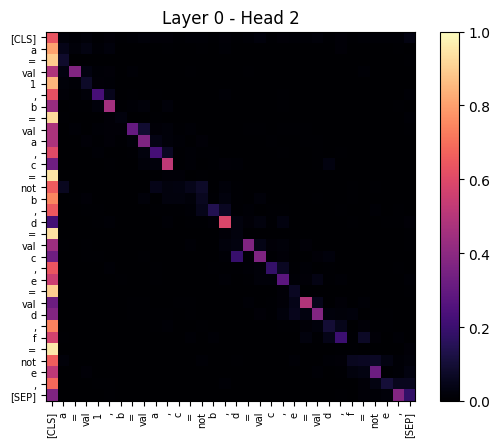

In [11]:
n_layer = 0 # We look at layer 0
n_head = 2 # We look at the second head

head = pred[2][n_layer][0, n_head, :, :]
head_np = np.array( [ [head[i][j].item() for j in range(len(head))] for i in range(len(head))])

fig, ax = plt.subplots(1,1)
ax_label = tokenizer.convert_ids_to_tokens(x[0])

c = ax.imshow(head_np, cmap = 'magma', vmin = 0, vmax = 1)

ax.set_xticks(list(range(len(head))))
ax.set_xticklabels(ax_label, size = 7)
plt.xticks(rotation = 90)

ax.set_yticks(list(range(len(head))))
ax.set_yticklabels(ax_label, size = 7)

plt.colorbar(c)

plt.title(f'Layer {n_layer} - Head {n_head}')